# SETUP

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# import os

In [2]:
# import csv

# # Define the path to your folder in Google Drive
# folder_path = '/content/drive/My Drive/Deep Learning Project'

# # Create the folder if it doesn't exist
# if not os.path.exists(folder_path):
#     os.makedirs(folder_path)

# # Write a simple message to the test file
# test_file_path = os.path.join(folder_path, 'test_file.txt')
# with open(test_file_path, 'w') as file:
#     file.write('Filepath test successful!')

# print(f'Test file created at: {test_file_path}')

In [3]:
#!pip install laplace-torch --upgrade

### Import all dependencies

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import sympy
import torchvision

import torchvision.transforms as transforms
from torchvision.utils import make_grid
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [5]:
sns.set_theme(style="whitegrid")

### import CIFAR-10

In [6]:
# 1. Download CIFAR-10
cifar10_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
cifar10_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

# 2. Access data and targets
X_train = np.array([np.array(x) for x, y in cifar10_train])
y_train = np.array([y for x, y in cifar10_train])

X_test = np.array([np.array(x) for x, y in cifar10_test])
y_test = np.array([y for x, y in cifar10_test])

# Map from class index to class name.
classes = {index: name for name, index in cifar10_train.class_to_idx.items()}

Files already downloaded and verified
Files already downloaded and verified


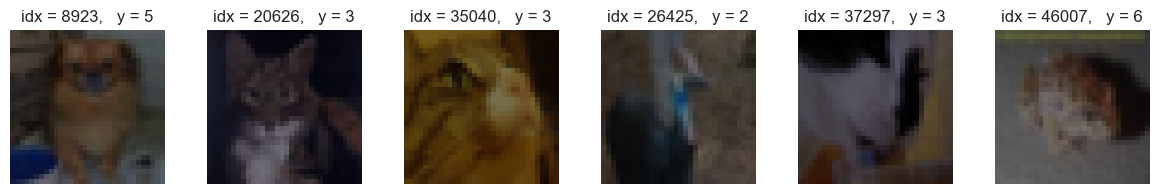

In [7]:
def plot_random_examples(X, y, num_examples=5):
    """
    Plots a given number of random examples from the dataset.
    """
    num_images = X.shape[0]

    plt.figure(figsize=(num_examples * 2, 2))
    random_indices = np.random.choice(num_images, num_examples, replace=False)

    for i, idx in enumerate(random_indices):
        image = X[idx].reshape(32, 32, 3)/255 # Reshape for CIFAR-10
        plt.subplot(1, num_examples, i + 1)
        plt.imshow(image/2.1295387686331444)
        plt.axis('off')
        plt.title(f"idx = {idx},   y = {y[idx]}")

    plt.tight_layout()
    plt.show()

plot_random_examples(X_train, y_train, 6)

In [8]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print(classes)

X_train shape: (50000, 32, 32, 3)
y_train shape: (50000,)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000,)
{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


In [9]:
# 3. Split data
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

### Normalize X

In [10]:
mean = np.mean(X_train, axis=(0, 1, 2))
std = np.std(X_train, axis=(0, 1, 2))

In [11]:
X_train = (X_train - mean) / std
X_val = (X_val - mean) / std
X_test = (X_test - mean) / std

print("X_train min/max:", X_train.min(), X_train.max())
print("X_val min/max:", X_val.min(), X_val.max())
print("X_test min/max:", X_test.min(), X_test.max())

X_train min/max: -1.9909929603437044 2.1295387686331444
X_val min/max: -1.9909929603437044 2.1295387686331444
X_test min/max: -1.9909929603437044 2.1295387686331444


### Define Classification Class

In [12]:
import torch.nn.init as init
from copy import deepcopy

In [13]:
class CIFAR10ClassifierModule(nn.Module):
    def __init__(self, num_classes=10):
        super(CIFAR10ClassifierModule, self).__init__()

        # Convolutional layer dimensions
        self.dim1 = 16
        self.dim2 = 32
        self.dim3 = 64

        # Convolutional Layers
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=self.dim1, kernel_size=3, stride=1, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(self.dim1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv_layer2 = nn.Conv2d(in_channels=self.dim1, out_channels=self.dim2, kernel_size=3, stride=1, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(self.dim2)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv_layer3 = nn.Conv2d(in_channels=self.dim2, out_channels=self.dim3, kernel_size=3, stride=1, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(self.dim3)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=4, stride=4)

        # Fully Connected Layers
        self.fc_layer1 = nn.Linear(self.dim3*4, self.dim3*8)
        self.relu5 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.3)

        self.fc_layer2 = nn.Linear(self.dim3*8, num_classes)

        # Initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            init.kaiming_normal_(module.weight, nonlinearity='relu')
            if module.bias is not None:
                init.constant_(module.bias, 0)
        # Save the initial parameters after weights are initialized
        self.init_params = deepcopy(self.state_dict())

    def compute_features(self,X):
        self.eval()
        with torch.no_grad():
            X = self.conv_layer1(X)
            X = self.batchnorm1(X)
            X = self.relu1(X)
            X = self.pool1(X)


            X = self.conv_layer2(X)
            X = self.batchnorm2(X)
            X = self.relu2(X)
            X = self.pool2(X)


            X = self.conv_layer3(X)
            X = self.batchnorm3(X)
            X = self.relu3(X)
            X = self.pool3(X)
            return X.view(X.size(0), -1)
            #X = self.global_avg_pool(X)

        return X.squeeze(-1).squeeze(-1)


    def forward(self, X, **kwargs):
        feature_maps = {}

        # Convolutional Layer 1
        X = self.conv_layer1(X)
        X = self.batchnorm1(X)
        X = self.relu1(X)
        feature_maps['conv1'] = X
        X = self.pool1(X)

        # Convolutional Layer 2
        X = self.conv_layer2(X)
        X = self.batchnorm2(X)
        X = self.relu2(X)
        feature_maps['conv2'] = X
        X = self.pool2(X)

        # Convolutional Layer 3
        X = self.conv_layer3(X)
        X = self.batchnorm3(X)
        X = self.relu3(X)
        feature_maps['conv3'] = X
        X = self.pool3(X)

        # Global Average Pooling
        #X = self.global_avg_pool(X)  # Shape: (batch_size, dim4, 1, 1)
        X = X.view(X.size(0), -1)    # Shape: (batch_size, dim4)
        #feature_maps['final'] = X

        # Fully Connected Layer 1
        X = self.fc_layer1(X)
        X = self.relu5(X)
        X = self.dropout1(X)

        # Fully Connected Layer 2 (New)
        X = self.fc_layer2(X)

        if kwargs.get("laplace_context", False):  # Check for laplace_context flag
            return X  # Return only the output
        else:
            return X, feature_maps  # Return output and feature maps as usual

    def reset(self):
        self.load_state_dict(self.init_params)

    def save_checkpoint(self, optimizer, epoch, path):
        """
        Saves the model and optimizer states to the specified path.
        """
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }
        torch.save(checkpoint, path)
        print(f"Model and optimizer states saved to {path}")

    def load_checkpoint(self, optimizer, path, device):
        """
        Loads the model and optimizer states from the specified path.
        """
        checkpoint = torch.load(path, map_location=device, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        print(f"Model and optimizer states loaded from {path} (Epoch {epoch})")
        return epoch

# Instantiate and print the model
model = CIFAR10ClassifierModule()
print(model)


CIFAR10ClassifierModule(
  (conv_layer1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_layer2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_layer3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc_layer1): Linear(in_features=256, out_features=512, bias=True)
  (relu5): ReLU()
  (dropout1): Dropout(p=0.3, inplace=Fals

In [14]:
def count_parameters(model):
    """
    Counts and prints the number of parameters in each layer of the model,
    as well as the total number of parameters.
    """
    total_params = 0
    layer_params = {}

    print("Layer-wise Parameter Count:\n" + "-"*30)
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.BatchNorm2d, nn.Linear)):
            params = sum(p.numel() for p in module.parameters())
            layer_params[name] = params
            total_params += params
            print(f"{name:<20} | {params:<10}")

    print("-"*30)
    print(f"{'Total Parameters':<20} | {total_params}")

# Call the function to display parameter counts
count_parameters(model)

Layer-wise Parameter Count:
------------------------------
conv_layer1          | 448       
batchnorm1           | 32        
conv_layer2          | 4640      
batchnorm2           | 64        
conv_layer3          | 18496     
batchnorm3           | 128       
fc_layer1            | 131584    
fc_layer2            | 5130      
------------------------------
Total Parameters     | 160522


In [15]:
def check_model_grad_flow(model, input_shape=(3, 32, 32), num_classes=10):
    """
    Checks a PyTorch model for gradient-related issues and potential clashes with higher-order derivatives.

    Args:
        model: The PyTorch model to check.
        input_shape: Tuple, shape of the input tensor.
        num_classes: Integer, number of classes for the output (default: 10 for CIFAR-10).
    """
    print("=== Model Check Report ===")
    print("\n1. Checking if all parameters require gradients:")
    for name, param in model.named_parameters():
        print(f"{name}: requires_grad={param.requires_grad}")

    print("\n2. Running a forward pass...")
    try:
        inputs = torch.randn(2, *input_shape)  # Batch size of 2
        outputs, _ = model(inputs)
        if outputs.size(1) != num_classes:
            print(f"[WARNING] Output size mismatch: expected {num_classes} classes, got {outputs.size(1)}.")
        print("[SUCCESS] Forward pass completed.")
    except Exception as e:
        print(f"[ERROR] Forward pass failed: {e}")
        return

    print("\n3. Checking first-order gradients...")
    try:
        labels = torch.tensor([0, 1])  # Dummy labels
        loss = nn.CrossEntropyLoss()(outputs, labels)
        grads = torch.autograd.grad(loss, model.parameters(), create_graph=True)
        for i, grad in enumerate(grads):
            if grad is None or not grad.requires_grad:
                print(f"[WARNING] Gradient issue for parameter {list(model.parameters())[i].shape}.")
        print("[SUCCESS] First-order gradients computed.")
    except Exception as e:
        print(f"[ERROR] First-order gradient computation failed: {e}")
        return

    print("\n4. Checking second-order gradients...")
    try:
        for param in model.parameters():
            if param.requires_grad:
                grad = torch.autograd.grad(loss, param, create_graph=True, retain_graph=True)[0]
                if grad is not None:
                    grad2 = torch.autograd.grad(grad, param, grad_outputs=torch.ones_like(grad), retain_graph=True)[0]
                    if grad2 is None:
                        print(f"[WARNING] Second-order gradient issue for parameter {param.shape}.")
        print("[SUCCESS] Second-order gradients computed.")
    except Exception as e:
        print(f"[ERROR] Second-order gradient computation failed: {e}")

    print("\n5. Checking BatchNorm and ReLU layers...")
    for name, module in model.named_modules():
        if isinstance(module, nn.BatchNorm2d):
            print(f"BatchNorm layer '{name}': affine={module.affine}, track_running_stats={module.track_running_stats}")
        elif isinstance(module, nn.ReLU):
            print(f"ReLU layer '{name}': inplace={module.inplace}")

    print("\n6. Checking custom initialization...")
    try:
        model.apply(model._init_weights)
        print("[SUCCESS] Custom initialization passed.")
    except Exception as e:
        print(f"[ERROR] Custom initialization failed: {e}")

    print("\n=== End of Report ===")


# Example Usage
model = CIFAR10ClassifierModule()
check_model_grad_flow(model)


=== Model Check Report ===

1. Checking if all parameters require gradients:
conv_layer1.weight: requires_grad=True
conv_layer1.bias: requires_grad=True
batchnorm1.weight: requires_grad=True
batchnorm1.bias: requires_grad=True
conv_layer2.weight: requires_grad=True
conv_layer2.bias: requires_grad=True
batchnorm2.weight: requires_grad=True
batchnorm2.bias: requires_grad=True
conv_layer3.weight: requires_grad=True
conv_layer3.bias: requires_grad=True
batchnorm3.weight: requires_grad=True
batchnorm3.bias: requires_grad=True
fc_layer1.weight: requires_grad=True
fc_layer1.bias: requires_grad=True
fc_layer2.weight: requires_grad=True
fc_layer2.bias: requires_grad=True

2. Running a forward pass...
[SUCCESS] Forward pass completed.

3. Checking first-order gradients...
[SUCCESS] First-order gradients computed.

4. Checking second-order gradients...
[SUCCESS] Second-order gradients computed.

5. Checking BatchNorm and ReLU layers...
BatchNorm layer 'batchnorm1': affine=True, track_running_stat

# ACTIVE LEARNING TRAINER

### Class Initialization

We generate an unlabeled dataset and a labeled dataset:

In [16]:
from torch.utils.data import random_split, TensorDataset

# Define initial labeled and unlabeled datasets
initial_train_size = int(len(X_train)*0.1) # Small initial training set
val_size = int(len(X_train) * 0.1) # Validation set size
unlabeled_size = len(X_train) - initial_train_size - val_size

# Convert CIFAR-10 numpy arrays to TensorDatasets
train_dataset = TensorDataset(torch.tensor(X_train).permute(0, 3, 1, 2).float(), torch.tensor(y_train))
test_dataset = TensorDataset(torch.tensor(X_test).permute(0, 3, 1, 2).float(), torch.tensor(y_test))

# Split CIFAR-10 into labeled training, validation, and unlabeled sets
train_data, val_data, unlabeled_data = random_split(train_dataset, [initial_train_size, val_size, unlabeled_size])

# ACTIVE LEARNER WITH LAPLACE

In [17]:
from torch.utils.data import Subset
import collections

class ActiveLearningTrainer:
    def __init__(self, model, criterion, optimizer, test_data, train_data, val_data, unlabeled_data,
                 subset_size=2000, batch_size=128, device=None, posterior="plugin",
                 sampling_strategy="entropy", num_cycles=5, epochs_per_cycle=10, num_samples_per_cycle=100,
                 convergence_threshold=1e-3, convergence_epochs=2, alpha=1, init_epochs=50, pretrain=True,
                 epoch_print=True,sim_batch_size=512):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_data = train_data
        self.val_data = val_data
        self.unlabeled_data = unlabeled_data
        self.test_data = test_data
        self.train_loader = DataLoader(self.train_data, batch_size=batch_size, shuffle=True)
        self.val_loader = DataLoader(self.val_data, batch_size=batch_size, shuffle=False)
        self.unlabeled_loader = DataLoader(self.unlabeled_data, batch_size=batch_size, shuffle=False)
        self.test_loader = DataLoader(self.test_data, batch_size=batch_size, shuffle=False)
        self.device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.posterior = posterior
        self.sampling_strategy = sampling_strategy
        if posterior == "laplace":
            self.laplace_approximation = LaplaceApproximation(self)
        else:
            self.laplace_approximation = None

        self.subset_size = subset_size
        self.init_epochs = init_epochs

        self.num_cycles = num_cycles
        self.epochs_per_cycle = epochs_per_cycle
        self.num_samples_per_cycle = num_samples_per_cycle

        self.convergence_epochs = convergence_epochs

        self.alpha = alpha

        self.pretrain = pretrain

        self.epoch_print=epoch_print


        self.model.to(self.device)

    def compute_output(self, inputs, laplace = True):
        if self.posterior == "plugin":
            outputs, _ = self.model(inputs)
            probabilities = F.softmax(outputs, dim=1)
        elif self.posterior == "laplace" and laplace == True:
            probabilities = self.laplace_approximation.bayesian_output(inputs, N=30)
        else:
            raise ValueError(f"Unsupported posterior method: {self.posterior}")
        return probabilities

    def entropy_score(self, inputs,laplace = True):
        """
        Compute entropy of the model's outputs to measure uncertainty.
        """
        prob = self.compute_output(inputs, laplace)
        entropy = -torch.sum(prob * torch.log(prob + 1e-16), dim=1)
        return entropy

    def margin_score(self, inputs):
        """
        Compute margin scores of the model's outputs to measure uncertainty.
        """
        prob = self.compute_output(inputs)
        top2_probs, _ = torch.topk(prob, 2, dim=1)
        margin_scores = top2_probs[:, 0] - top2_probs[:, 1]
        return margin_scores

    def redundancy_score(self, inputs):
        features = self.model.compute_features(inputs)

        epsilon = 1e-8
        norm = features.norm(dim=1, keepdim=True) + epsilon

        features = features / norm

        similarity_matrix = torch.mm(features, features.T)
        similarity_matrix.fill_diagonal_(0)

        redundancy_scores = torch.sum(similarity_matrix, dim=1)

        return redundancy_scores

    def select_samples(self, num_samples):
        """Select samples based on the specified sampling strategy."""
        subset_size = self.subset_size
        if subset_size > len(self.unlabeled_data):
            subset_size = len(self.unlabeled_data)

        if self.sampling_strategy == "entropy":
            # Select samples with the highest entropy from a subset of the unlabeled data
            self.model.eval()
            entropies = []
            indices = []

            subset_size = min(subset_size, len(self.unlabeled_data))
            subset_indices = np.random.choice(len(self.unlabeled_data), size=subset_size, replace=False)
            subset_loader = DataLoader(Subset(self.unlabeled_data, subset_indices),
                                      batch_size=self.subset_size, shuffle=False)

            with torch.no_grad():
                for idx, (inputs, _) in enumerate(subset_loader):
                    inputs = inputs.to(self.device)
                    entropy = self.entropy_score(inputs)
                    entropies.extend(entropy.cpu().numpy())
                    indices.extend([subset_indices[idx * subset_loader.batch_size + i]
                                    for i in range(len(inputs))])

            selected_indices = np.argsort(entropies)[-num_samples:]
            return [indices[i] for i in selected_indices]

        elif self.sampling_strategy == "entropy-redundancy":
            self.model.eval()
            entropies = []
            indices = []

            subset_size = min(subset_size, len(self.unlabeled_data))
            subset_indices = np.random.choice(len(self.unlabeled_data), size=subset_size, replace=False)
            subset_loader = DataLoader(Subset(self.unlabeled_data, subset_indices),
                                        batch_size=self.unlabeled_loader.batch_size, shuffle=False)

            with torch.no_grad():
                for batch_idx, (inputs, _) in enumerate(subset_loader):
                    inputs = inputs.to(self.device)

                    # Calculate entropy and redundancy for the entire batch
                    batch_entropy = self.entropy_score(inputs)
                    batch_redundancy = self.redundancy_score(inputs)

                    # Combine entropy and redundancy scores
                    combined_scores = batch_entropy - (self.alpha / len(batch_redundancy)) * batch_redundancy

                    # Extend the scores and indices for the current batch
                    entropies.extend(combined_scores.cpu().numpy())
                    indices.extend([subset_indices[batch_idx * subset_loader.batch_size + i]
                                    for i in range(len(inputs))])

            # Select the top samples based on the combined scores
            selected_indices = np.argsort(entropies)[-num_samples:]
            return [indices[i] for i in selected_indices]

        if self.sampling_strategy == "margin":
            # Select samples with the highest entropy from a subset of the unlabeled data
            self.model.eval()
            margins = []
            indices = []

            subset_size = min(subset_size, len(self.unlabeled_data))
            subset_indices = np.random.choice(len(self.unlabeled_data), size=subset_size, replace=False)
            subset_loader = DataLoader(Subset(self.unlabeled_data, subset_indices),
                                      batch_size=self.unlabeled_loader.batch_size, shuffle=False)

            with torch.no_grad():
                for idx, (inputs, _) in enumerate(subset_loader):
                    inputs = inputs.to(self.device)
                    margin = self.margin_score(inputs)
                    margins.extend(margin.cpu().numpy())
                    indices.extend([subset_indices[idx * subset_loader.batch_size + i]
                                    for i in range(len(inputs))])

            selected_indices = np.argsort(margins)[-num_samples:]
            return [indices[i] for i in selected_indices]
        elif self.sampling_strategy == "random":
            # Randomly select samples from the unlabeled data
            remaining_indices = list(range(len(self.unlabeled_data)))
            if num_samples >= len(remaining_indices):
                selected_indices = remaining_indices
            else:
                selected_indices = np.random.choice(remaining_indices, size=num_samples, replace=False)
            return selected_indices.tolist()
        else:
            raise ValueError(f"Unsupported sampling strategy: {self.sampling_strategy}")




    def add_to_train_set(self, selected_indices):
        """Add selected samples to the training set."""
        new_train_indices = list(range(len(self.train_data))) + selected_indices
        self.train_data = Subset(self.train_data + self.unlabeled_data, new_train_indices)
        self.train_loader = DataLoader(self.train_data, batch_size=self.train_loader.batch_size, shuffle=True)

    def train_epoch(self):
        """Train for one epoch with the current training data."""
        self.model.train()
        running_loss = 0.0

        for inputs, labels in self.train_loader:
            inputs, labels = inputs.to(self.device), labels.to(self.device).long()

            self.optimizer.zero_grad()
            outputs, _ = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(self.train_loader.dataset)
        return epoch_loss

    def validate(self):
        self.model.eval()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0

        with torch.no_grad():
            for inputs, labels in self.val_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device).long()
                outputs, _ = self.model(inputs)
                loss = self.criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)

                _, preds = torch.max(outputs, 1)
                running_corrects += (preds == labels).sum().item()
                total_samples += labels.size(0)

        avg_loss = running_loss / total_samples
        accuracy = running_corrects / total_samples
        return avg_loss, accuracy

    def compute_test_metrics(self):
        self.model.eval()

        correct_predictions, total_samples = 0, 0
        total_loss = 0

        with torch.no_grad():
            for inputs, labels in self.test_loader:  # Use your pre-defined test_loader
                inputs, labels = inputs.to(self.device), labels.to(self.device).long()
                outputs, _ = self.model(inputs)

                # Compute loss
                total_loss += self.criterion(outputs, labels).item()

                # Compute predictions
                _, preds = torch.max(outputs, 1)
                correct_predictions += (preds == labels).sum().item()
                total_samples += labels.size(0)

        accuracy = correct_predictions / total_samples
        average_loss = total_loss / len(self.test_loader)
        return average_loss, accuracy

    def active_learning_training(self):
        """Main training loop with active learning."""
        metrics = {
            "cycle": [],
            "train_loss": [],
            "val_loss": [],
            "val_accuracy": [],
            "train_sample_size": [],
            "test_accuracy": [],
            "test_loss": [],
            "average_entropy": []
        }

        print("Evaluating initial metrics...")
        initial_val_loss, initial_val_accuracy = self.validate()
        if self.epoch_print: print(f"Initial Validation Loss: {initial_val_loss:.4f}, Accuracy: {initial_val_accuracy:.4f}\n")

        # Calculate total epochs for logging purposes
        pretrain_epochs = self.init_epochs if self.pretrain else 0
        total_epochs = pretrain_epochs + (self.num_cycles * self.epochs_per_cycle)
        print("Max Scheduled Epochs: ", total_epochs)
        current_epoch = 0

        # **Pre-training Phase:** Only if pretrain is True
        if self.pretrain:
            print("Starting Pre-training Phase...")

            recent_train_losses = collections.deque(maxlen=self.convergence_epochs)
            recent_val_losses = collections.deque(maxlen=self.convergence_epochs)

            lowest_train_loss = float('inf')
            lowest_val_loss = float('inf')

            for epoch in range(self.init_epochs):
                current_epoch += 1
                print(f"  Pre-training Epoch {epoch + 1}/{self.init_epochs}")

                # Train
                train_loss = self.train_epoch()
                print(f"    Training Loss: {train_loss:.4f}")

                # Update Laplace (if applicable)
                if self.laplace_approximation:
                    self.laplace_approximation.update()

                # Validate
                val_loss, val_accuracy = self.validate()
                print(f"    Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")

                # Update recent losses for convergence check
                recent_train_losses.append(train_loss)
                recent_val_losses.append(val_loss)

                # Check for convergence
                if (len(recent_train_losses) == self.convergence_epochs and
                    len(recent_val_losses) == self.convergence_epochs):

                    # Determine if training has converged
                    train_converged = min(recent_train_losses) > lowest_train_loss
                    val_converged = min(recent_val_losses) > lowest_val_loss
                    if train_converged and val_converged:
                        print(f"  Convergence reached!")
                        break

                # Update lowest losses
                if train_loss < lowest_train_loss:
                    lowest_train_loss = train_loss
                if val_loss < lowest_val_loss:
                    lowest_val_loss = val_loss

                # Record overall training metrics

            # Compute and store test metrics after pre-training
            test_loss, test_accuracy = self.compute_test_metrics()
            print(f"Test Loss after Pre-training: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

            # Compute average entropy after pre-training
            entropy_scores = []
            self.model.eval()
            with torch.no_grad():
                for inputs, _ in self.val_loader:
                    inputs = inputs.to(self.device)
                    entropy = self.entropy_score(inputs)
                    entropy_scores.extend(entropy.cpu().numpy())
            average_entropy = float(np.mean(entropy_scores))
            print(f"Average Entropy after Pre-training: {average_entropy:.4f}\n")

        for cycle in range(1, self.num_cycles + 1):
            print(f"\nCycle {cycle}/{self.num_cycles}")

            # **Sample Acquisition Phase:** Before the start of the cycle
            print(f"\nSelecting {self.num_samples_per_cycle} Samples - Sampling Strategy: '{self.sampling_strategy}'")
            selected_indices = self.select_samples(self.num_samples_per_cycle)
            self.add_to_train_set(selected_indices)
            print(f"Current training set size: {len(self.train_data)}")

            # Update unlabeled data by removing selected indices
            remaining_unlabeled_indices = set(range(len(self.unlabeled_data))) - set(selected_indices)
            self.unlabeled_data = Subset(self.unlabeled_data, list(remaining_unlabeled_indices))

            # Update the DataLoader for unlabeled data
            self.unlabeled_loader = DataLoader(
                self.unlabeled_data,
                batch_size=self.unlabeled_loader.batch_size,
                shuffle=False
            )

            # Check if unlabeled data is exhausted
            if len(self.unlabeled_data) == 0:
                print("No unlabeled data left. Ending active learning early.")
                break

            # Record metrics for the current cycle
            metrics["train_sample_size"].append(len(self.train_data))
            metrics["cycle"].append(cycle)

            # Reset metrics for convergence detection
            recent_train_losses = collections.deque(maxlen=self.convergence_epochs)
            recent_val_losses = collections.deque(maxlen=self.convergence_epochs)

            lowest_train_loss = float('inf')
            lowest_val_loss = float('inf')

            # Training phase for the cycle
            for epoch in range(self.epochs_per_cycle):
                current_epoch += 1


                # Train
                train_loss = self.train_epoch()

                # Update Laplace (if applicable)
                if self.laplace_approximation:
                    self.laplace_approximation.update()

                # Validate
                val_loss, val_accuracy = self.validate()
                if self.epoch_print == True:
                  print(f"  Epoch {epoch + 1}/{self.epochs_per_cycle}")
                  print(f"    Training Loss: {train_loss:.4f}")
                  print(f"    Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")

                # Update recent losses for convergence check
                recent_train_losses.append(train_loss)
                recent_val_losses.append(val_loss)

                # Check for convergence
                if len(recent_val_losses) == self.convergence_epochs:
                    # Check if validation loss has not improved for `convergence_epochs`
                    if min(recent_val_losses) >= lowest_val_loss:
                        print(f"  Convergence reached! Validation loss has not improved for {self.convergence_epochs} epochs.")
                        break

                # Update lowest losses
                if train_loss < lowest_train_loss:
                    lowest_train_loss = train_loss
                if val_loss < lowest_val_loss:
                    lowest_val_loss = val_loss

            # After training epochs for the cycle, record the last epoch's loss and accuracy
            metrics["train_loss"].append(train_loss)
            metrics["val_loss"].append(val_loss)
            metrics["val_accuracy"].append(val_accuracy)

            # Compute and store test metrics
            test_loss, test_accuracy = self.compute_test_metrics()
            metrics["test_accuracy"].append(test_accuracy)
            metrics["test_loss"].append(test_loss)
            print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

            # Compute average entropy for the current cycle
            entropy_scores = []
            self.model.eval()
            with torch.no_grad():
                for inputs, _ in self.val_loader:
                    inputs = inputs.to(self.device)
                    entropy = self.entropy_score(inputs,laplace = True)
                    entropy_scores.extend(entropy.cpu().numpy())
            average_entropy = float(np.mean(entropy_scores))
            metrics["average_entropy"].append(average_entropy)
            print(f"Average Entropy: {average_entropy:.4f}")

            # Check if unlabeled data is exhausted
            if len(self.unlabeled_data) == 0:
                print("No unlabeled data left. Ending active learning early.")
                break

        print("Training Finalized!\n")
        return metrics

# LAPLACE APPROXIMATION

In [18]:
class LaplaceApproximation:
    def __init__(self, trainer):
        self.trainer = trainer
        self.model = trainer.model
        self.criterion = trainer.criterion
        self.device = trainer.device
        self.update()  # Initial update

    def update(self):
        # Update the MAP estimate
        map_params = []
        for param in self.model.parameters():
            map_params.append(param.view(-1))
        self.map = torch.cat(map_params)

        # Compute Hessian diagonal over the training data
        hessian_diag = None
        for inputs, labels in self.trainer.train_loader:
            diag = self.compute_hessian_diag(inputs, labels)
            if hessian_diag is None:
                hessian_diag = diag
            else:
                hessian_diag += diag
        hessian_diag /= len(self.trainer.train_loader)
        self.hessian_diag = hessian_diag

    def compute_hessian_diag(self, inputs, labels):
        # Ensure gradient computation is enabled within the function
        with torch.set_grad_enabled(True):
            self.model.train()
            inputs, labels = inputs.to(self.device), labels.to(self.device).long()
            outputs, _ = self.model(inputs)
            loss = self.criterion(outputs, labels)

            hessian_diag = []

            for param in self.model.parameters():
                # First derivative
                grad = torch.autograd.grad(loss, param, create_graph=True, retain_graph=True)[0]
                # Second derivative
                grad2 = torch.autograd.grad(grad, param, grad_outputs=torch.ones_like(grad), retain_graph=True)[0]
                hessian_diag.append(grad2.view(-1))

            return torch.cat(hessian_diag)

    def get_laplace_dist(self, inputs, labels):
        hessian_diag = self.hessian_diag

        damping = 1e-3
        hessian_diag_damped = hessian_diag + damping

        min_hessian_value = 1e-16
        hessian_diag_damped = torch.clamp(hessian_diag_damped, min=min_hessian_value)

        variance_diag = torch.reciprocal(hessian_diag_damped)

        max_variance = 1e6
        variance_diag = torch.clamp(variance_diag, max=max_variance)

        dist = torch.distributions.Independent(
            torch.distributions.Normal(self.map, variance_diag.sqrt()),
            reinterpreted_batch_ndims=1
        )
        return dist

    def bayesian_output(self, inputs, N=50):
        inputs = inputs.to(self.device)

        dist = self.get_laplace_dist(inputs, torch.zeros(inputs.size(0), device=self.device))

        # Compute the MAP output
        self._assign_parameters(self.map)
        map_output, _ = self.model(inputs)

        thetas = [dist.sample() for _ in range(N - 1)]
        thetas.append(self.map)

        probabilities = None
        for theta in thetas:
            self._assign_parameters(theta)
            output, _ = self.model(inputs)
            probs = F.softmax(output, dim=1)

            if probabilities is None:
                probabilities = probs
            else:
                probabilities += probs

        posterior_output = probabilities / N

        self._assign_parameters(self.map)

        #print(posterior_output,map_output)

        return posterior_output

    def _assign_parameters(self, theta):
        pointer = 0
        for param in self.model.parameters():
            num_params = param.numel()
            param.data.copy_(theta[pointer:pointer + num_params].view_as(param))
            pointer += num_params


# TRAINING MODELS

In [19]:
def train_initial(model, optimizer, criterion, train_data, val_data, test_data, init_epochs, batch_size, device):
    """
    Trains the model for a specified number of initial epochs, evaluates on validation/test data, and returns metrics.
    """

    # Prepare DataLoaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    # Initialize lists to hold metric values per epoch
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(init_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).long()

            optimizer.zero_grad()
            outputs, _ = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += (preds == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = running_corrects / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        # Validation Phase
        model.eval()
        running_val_loss = 0.0
        running_val_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).long()
                outputs, _ = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)

                _, preds = torch.max(outputs, 1)
                running_val_corrects += (preds == labels).sum().item()

        val_loss = running_val_loss / len(val_loader.dataset)
        val_accuracy = running_val_corrects / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{init_epochs} - "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_accuracy:.4f} - "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    print("\nInitial Training Completed!\n")

    # Test Phase
    running_test_loss = 0.0
    running_test_corrects = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device).long()
            outputs, _ = model(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)
            running_test_corrects += (preds == labels).sum().item()

            # If you're computing average_entropy, do it here
            # Example (placeholder):
            # probabilities = torch.softmax(outputs, dim=1)
            # entropy = -torch.sum(probabilities * torch.log(probabilities + 1e-10), dim=1).mean().item()
            # average_entropy_value += entropy  # Accumulate entropy for all batches

    test_loss = running_test_loss / len(test_loader.dataset)
    test_accuracy = running_test_corrects / len(test_loader.dataset)

    # If you computed entropy for each batch above, you should divide by number of batches here:
    # average_entropy_value = average_entropy_value / len(test_loader)  # if computed per batch

    print(f"Test Results - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}\n")

    # Example: train_sample_size might just be the size of the training dataset
    train_sample_size = len(train_loader.dataset)

    average_entropy_value = 0.0
    total_batches = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device).long()
            outputs, _ = model(inputs)
            probabilities = torch.softmax(outputs, dim=1)
            entropy = -(probabilities * torch.log(probabilities + 1e-10)).sum(dim=1).mean().item()

            average_entropy_value += entropy
            total_batches += 1

    average_entropy_value = average_entropy_value / total_batches

    # Initialize metrics dictionary
    metrics = {
        "train_loss": loss,
        "val_loss": val_loss,
        "val_accuracy": val_accuracy,
        "train_sample_size": train_sample_size,
        "test_accuracy": test_accuracy,
        "test_loss": test_loss,
        "average_entropy": average_entropy_value
    }

    # Plotting (optional, as you will use plot_metrics later)
    plt.figure(figsize=(8, 5),dpi=100)
    plt.plot(range(1, init_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, init_epochs + 1), val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Losses over Epochs')
    plt.legend()
    plt.show()

    plt.figure(figsize=(8, 5),dpi=100)
    plt.plot(range(1, init_epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, init_epochs + 1), val_accuracies, label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracies over Epochs')
    plt.legend()
    plt.show()

    return model, metrics


Starting Initial Training...

Epoch 1/40 - Train Loss: 3.1533, Train Acc: 0.1348 - Val Loss: 2.1335, Val Acc: 0.2293
Epoch 2/40 - Train Loss: 2.5048, Train Acc: 0.1965 - Val Loss: 1.9582, Val Acc: 0.2980
Epoch 3/40 - Train Loss: 2.2117, Train Acc: 0.2632 - Val Loss: 1.8825, Val Acc: 0.3237
Epoch 4/40 - Train Loss: 2.0473, Train Acc: 0.2878 - Val Loss: 1.8215, Val Acc: 0.3513
Epoch 5/40 - Train Loss: 1.9359, Train Acc: 0.3030 - Val Loss: 1.7804, Val Acc: 0.3688
Epoch 6/40 - Train Loss: 1.8556, Train Acc: 0.3375 - Val Loss: 1.7474, Val Acc: 0.3752
Epoch 7/40 - Train Loss: 1.7910, Train Acc: 0.3603 - Val Loss: 1.7161, Val Acc: 0.3910
Epoch 8/40 - Train Loss: 1.7200, Train Acc: 0.3860 - Val Loss: 1.6891, Val Acc: 0.4020
Epoch 9/40 - Train Loss: 1.6780, Train Acc: 0.4000 - Val Loss: 1.6785, Val Acc: 0.4045
Epoch 10/40 - Train Loss: 1.6365, Train Acc: 0.4168 - Val Loss: 1.6501, Val Acc: 0.4100
Epoch 11/40 - Train Loss: 1.6087, Train Acc: 0.4225 - Val Loss: 1.6308, Val Acc: 0.4165
Epoch 12/4

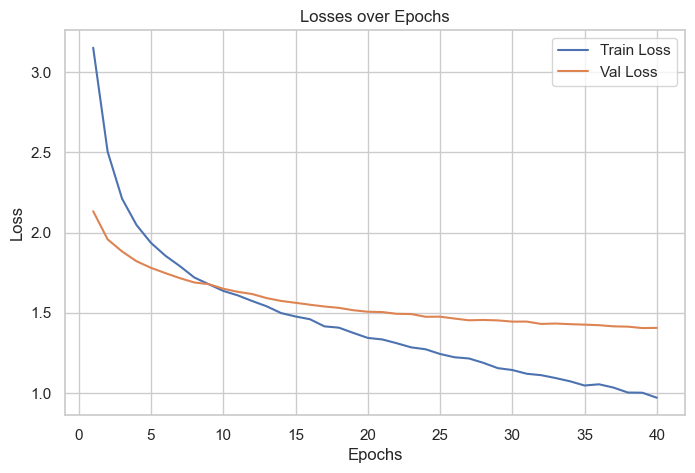

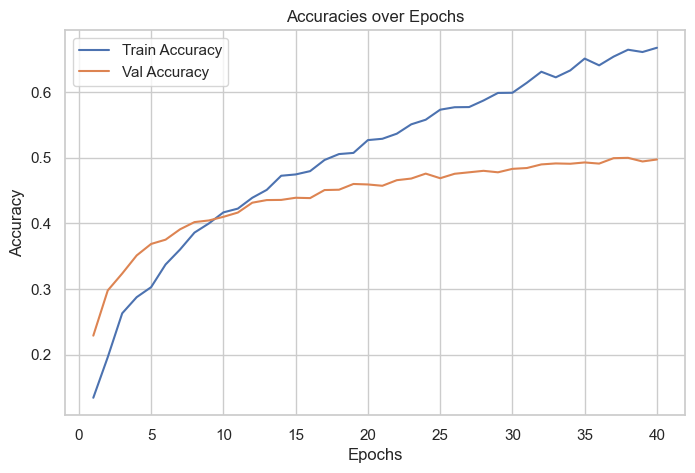

Model and optimizer states saved to pretrained.pth


In [20]:
model = CIFAR10ClassifierModule(num_classes=10)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0001
weight_decay = 0.00001
batch_size = 64
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


init_epochs = 40

# Initial Training (only once)
print("\nStarting Initial Training...\n")
model = CIFAR10ClassifierModule(num_classes=10)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

model, init_metrics = train_initial(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    train_data=train_data,
    val_data=val_data,
    test_data=test_dataset,
    init_epochs=init_epochs,
    batch_size=batch_size,
    device=device
)

save_path = "pretrained.pth"
model.save_checkpoint(optimizer, epoch=init_epochs, path=save_path)

In [21]:
# Active Learning Parameters
num_samples_per_cycle = batch_size*4
num_cycles = 15
epochs_per_cycle = 3
subset_size = len(X_train)//2
alpha = 0.2

from collections import defaultdict

# Function to set random seeds
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Number of runs to average
num_runs = 50
metrics_random = []
metrics_plugin_entropy = []
metrics_plugin_margin = []
metrics_plugin_entropy_redundancy = []
metrics_laplace_entropy = []
metrics_laplace_entropy_redundancy = []


for run in range(num_runs):
    print(f"\nRun {run + 1}/{num_runs}")
    seed = run
    set_seed(seed)

    # Load pretrained model
    model.load_checkpoint(optimizer, save_path, device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # RANDOM SAMPLING
    print("\nRANDOM SAMPLING")
    trainer_random = ActiveLearningTrainer(
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        train_data=train_data,
        val_data=val_data,
        test_data=test_dataset,
        unlabeled_data=unlabeled_data,
        batch_size=batch_size,
        posterior="plugin",
        sampling_strategy="random",
        num_cycles=num_cycles,
        epochs_per_cycle=epochs_per_cycle,
        num_samples_per_cycle=num_samples_per_cycle,
        subset_size=subset_size,
        pretrain=False,
        epoch_print=False
    )
    metrics_random.append(trainer_random.active_learning_training())

    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

    model.load_checkpoint(optimizer, save_path, device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


        # PLUGIN-APPROXIMATION - Entropy (Default)
    print("\nPLUGIN-APPROXIMATION - Margin")
    trainer_plugin = ActiveLearningTrainer(
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        train_data=train_data,
        val_data=val_data,
        test_data=test_dataset,
        unlabeled_data=unlabeled_data,
        batch_size=batch_size,
        posterior="plugin",
        sampling_strategy="margin",
        num_cycles=num_cycles,
        epochs_per_cycle=epochs_per_cycle,
        num_samples_per_cycle=num_samples_per_cycle,
        subset_size=subset_size,
        pretrain=False,
        alpha=alpha,
        epoch_print=False
    )
    metrics_plugin_margin.append(trainer_plugin.active_learning_training())

    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()


    model.load_checkpoint(optimizer, save_path, device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # PLUGIN-APPROXIMATION - Entropy (Default)
    print("\nPLUGIN-APPROXIMATION - Entropy (Default)")
    trainer_plugin = ActiveLearningTrainer(
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        train_data=train_data,
        val_data=val_data,
        test_data=test_dataset,
        unlabeled_data=unlabeled_data,
        batch_size=batch_size,
        posterior="plugin",
        sampling_strategy="entropy",
        num_cycles=num_cycles,
        epochs_per_cycle=epochs_per_cycle,
        num_samples_per_cycle=num_samples_per_cycle,
        subset_size=subset_size,
        pretrain=False,
        alpha=alpha,
        epoch_print=False
    )
    metrics_plugin_entropy.append(trainer_plugin.active_learning_training())

    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

    model.load_checkpoint(optimizer, save_path, device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    print("\nLaplace Approximation - Entropy")
    trainer_plugin = ActiveLearningTrainer(
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        train_data=train_data,
        val_data=val_data,
        test_data=test_dataset,
        unlabeled_data=unlabeled_data,
        batch_size=batch_size,
        posterior="laplace",
        sampling_strategy="entropy",
        num_cycles=num_cycles,
        epochs_per_cycle=epochs_per_cycle,
        num_samples_per_cycle=num_samples_per_cycle,
        subset_size=subset_size,
        pretrain=False,
        alpha=alpha,
        epoch_print=False
    )
    metrics_laplace_entropy.append(trainer_plugin.active_learning_training())

    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()



Run 1/50
Model and optimizer states loaded from pretrained.pth (Epoch 40)

RANDOM SAMPLING
Evaluating initial metrics...
Max Scheduled Epochs:  45

Cycle 1/15

Selecting 256 Samples - Sampling Strategy: 'random'
Current training set size: 4256
Test Loss: 1.3712, Test Accuracy: 0.5106
Average Entropy: 1.2850

Cycle 2/15

Selecting 256 Samples - Sampling Strategy: 'random'
Current training set size: 4512
  Convergence reached! Validation loss has not improved for 2 epochs.
Test Loss: 1.3693, Test Accuracy: 0.5113
Average Entropy: 1.2840

Cycle 3/15

Selecting 256 Samples - Sampling Strategy: 'random'
Current training set size: 4768
  Convergence reached! Validation loss has not improved for 2 epochs.
Test Loss: 1.3593, Test Accuracy: 0.5158
Average Entropy: 1.2438

Cycle 4/15

Selecting 256 Samples - Sampling Strategy: 'random'
Current training set size: 5024
  Convergence reached! Validation loss has not improved for 2 epochs.
Test Loss: 1.3588, Test Accuracy: 0.5185
Average Entropy: 1

KeyboardInterrupt: 

In [22]:
# Averaging results
def average_metrics(metrics_list):
    """
    Averages a list of metrics dictionaries, ensuring list values are averaged index-wise.
    """
    averaged_metrics = {}
    for key in metrics_list[0]:  # Iterate through keys in the first dictionary
        # Gather all values for the current key across all metrics
        values = [metrics[key] for metrics in metrics_list]

        # Handle list values by averaging element-wise (index-wise across metrics)
        if isinstance(values[0], list):
            max_len = max(len(v) for v in values)  # Determine the maximum length
            # Convert each list to float and pad shorter lists with NaNs
            padded_values = np.array([np.pad(np.array(v, dtype=float), (0, max_len - len(v)), constant_values=np.nan) for v in values])
            averaged_metrics[key] = np.nanmean(padded_values, axis=0).tolist()  # Average across rows (metrics)
        else:
            # Directly average scalar values
            averaged_metrics[key] = np.mean(values)
    return averaged_metrics

avg_metrics_random = average_metrics(metrics_random)
avg_metrics_plugin_margin = average_metrics(metrics_plugin_margin)
avg_metrics_plugin_entropy = average_metrics(metrics_plugin_entropy)
avg_metrics_laplace_entropy = average_metrics(metrics_laplace_entropy)


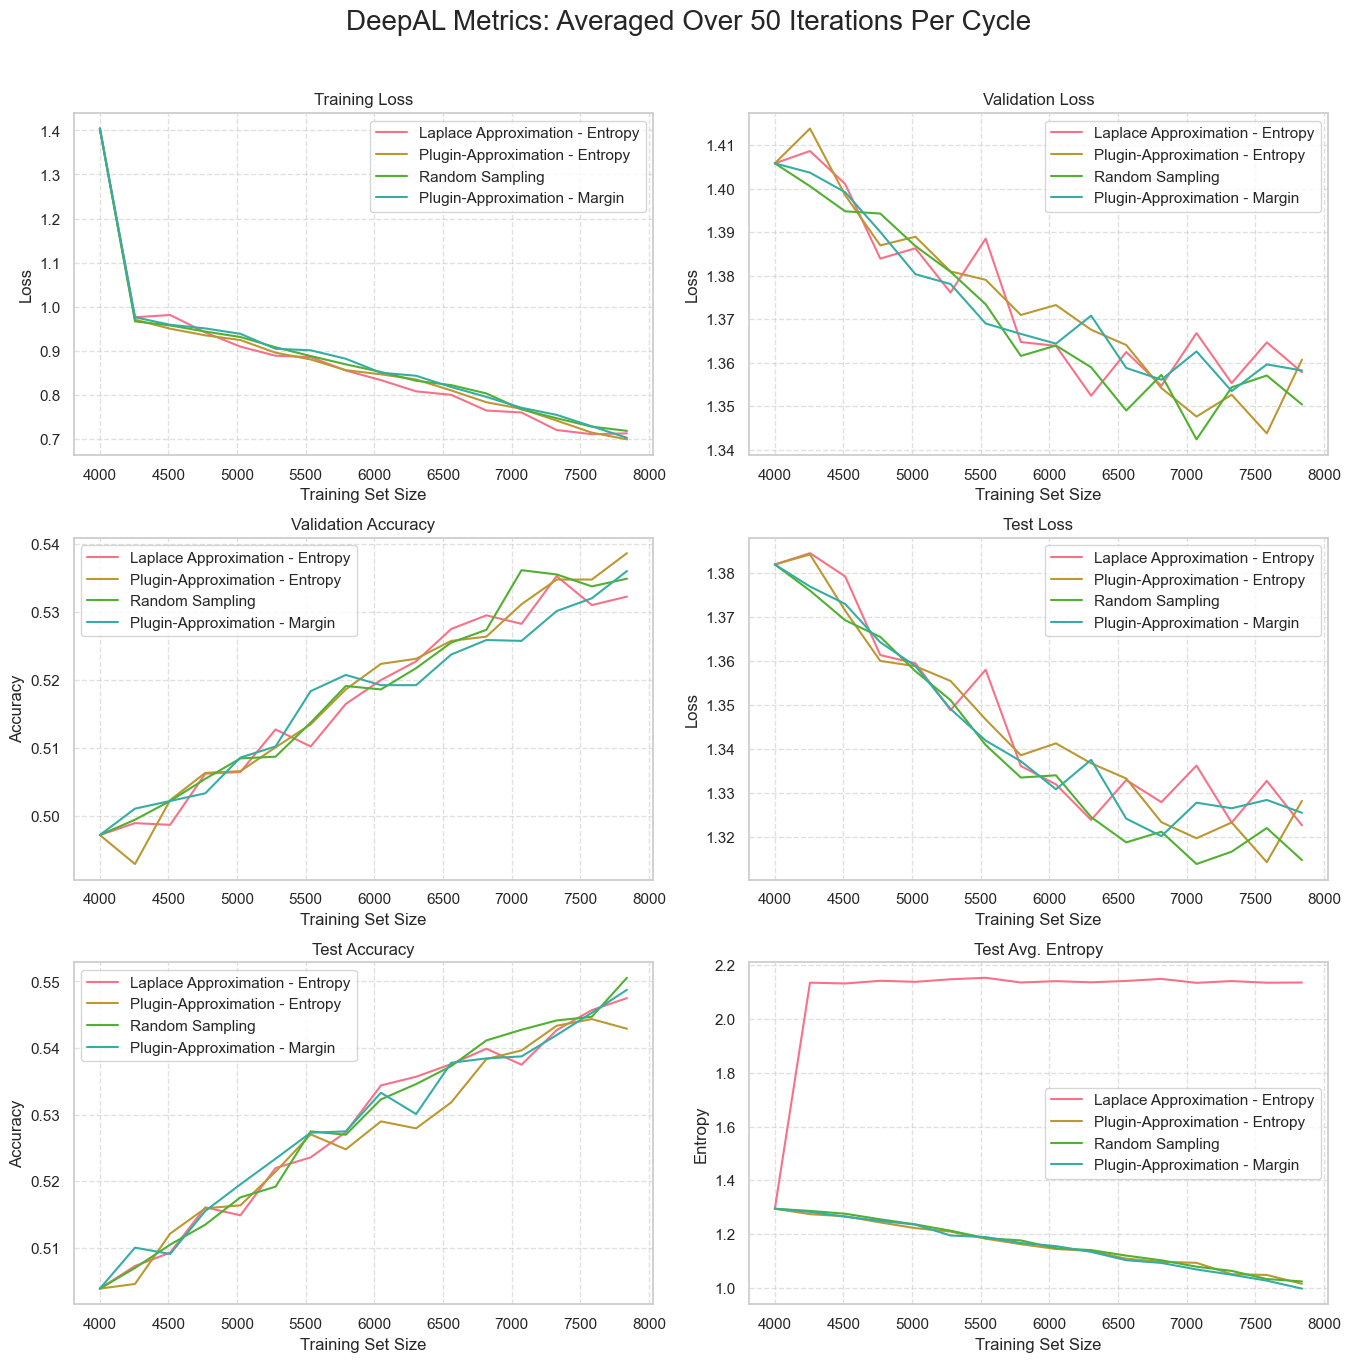

In [23]:
# @title Plot Averaged Metrics
# Define the plot_metrics function
def plot_metrics(metrics_list, init_metrics, labels, filename="metrics_plot.png"):
    sns.set_palette("husl")  # Use a harmonious color palette from Seaborn

    fig, axs = plt.subplots(3, 2, figsize=(14, 14))  # 3 rows, 2 columns
    fig.suptitle(f"DeepAL Metrics: Averaged Over {num_runs} Iterations Per Cycle", fontsize=20)
    fig.tight_layout(pad=3)

    # Flatten the 2D array of axes for easier indexing
    axs = axs.flatten()

    # Ensure all tensors are moved to CPU for plotting
    def to_cpu(data):
        if isinstance(data, torch.Tensor):
            return data.cpu().numpy()
        return data

    # Iterate over each metrics dictionary and its label
    for metrics, label in zip(metrics_list, labels):
        axs[0].plot(
            [to_cpu(init_metrics['train_sample_size'])] + to_cpu(metrics['train_sample_size']),
            [to_cpu(init_metrics['train_loss'])] + to_cpu(metrics['train_loss']),
            label=f'{label}'
        )
        axs[1].plot(
            [to_cpu(init_metrics['train_sample_size'])] + to_cpu(metrics['train_sample_size']),
            [to_cpu(init_metrics['val_loss'])] + to_cpu(metrics['val_loss']),
            label=f'{label}'
        )
        axs[2].plot(
            [to_cpu(init_metrics['train_sample_size'])] + to_cpu(metrics['train_sample_size']),
            [to_cpu(init_metrics['val_accuracy'])] + to_cpu(metrics['val_accuracy']),
            label=f'{label}'
        )
        axs[3].plot(
            [to_cpu(init_metrics['train_sample_size'])] + to_cpu(metrics['train_sample_size']),
            [to_cpu(init_metrics['test_loss'])] + to_cpu(metrics['test_loss']),
            label=f'{label}'
        )
        axs[4].plot(
            [to_cpu(init_metrics['train_sample_size'])] + to_cpu(metrics['train_sample_size']),
            [to_cpu(init_metrics['test_accuracy'])] + to_cpu(metrics['test_accuracy']),
            label=f'{label}'
        )
        axs[5].plot(
            [to_cpu(init_metrics['train_sample_size'])] + to_cpu(metrics['train_sample_size']),
            [to_cpu(init_metrics['average_entropy'])] + to_cpu(metrics['average_entropy']),
            label=f'{label}'
        )

    # Set titles, labels, and legends for subplots
    axs[0].set_xlabel('Training Set Size')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Training Loss')
    axs[0].grid(True, linestyle='--', alpha=0.6)
    axs[0].legend()

    axs[1].set_xlabel('Training Set Size')
    axs[1].set_ylabel('Loss')
    axs[1].set_title('Validation Loss')
    axs[1].grid(True, linestyle='--', alpha=0.6)
    axs[1].legend()

    axs[2].set_xlabel('Training Set Size')
    axs[2].set_ylabel('Accuracy')
    axs[2].set_title('Validation Accuracy')
    axs[2].grid(True, linestyle='--', alpha=0.6)
    axs[2].legend()

    axs[3].set_xlabel('Training Set Size')
    axs[3].set_ylabel('Loss')
    axs[3].set_title('Test Loss')
    axs[3].grid(True, linestyle='--', alpha=0.6)
    axs[3].legend()

    axs[4].set_xlabel('Training Set Size')
    axs[4].set_ylabel('Accuracy')
    axs[4].set_title('Test Accuracy')
    axs[4].grid(True, linestyle='--', alpha=0.6)
    axs[4].legend()

    axs[5].set_xlabel('Training Set Size')
    axs[5].set_ylabel('Entropy')
    axs[5].set_title('Test Avg. Entropy')
    axs[5].grid(True, linestyle='--', alpha=0.6)
    axs[5].legend()

    # Save the figure to a file
    plt.plot()
    fig.savefig(filename, bbox_inches='tight')

# Use averaged metrics for plotting
plot_metrics(
    [avg_metrics_laplace_entropy, avg_metrics_plugin_entropy, avg_metrics_random, avg_metrics_plugin_margin],
    init_metrics,
    ["Laplace Approximation - Entropy", "Plugin-Approximation - Entropy", "Random Sampling", "Plugin-Approximation - Margin"]
)

In [24]:
import csv
def save_dict_as_csv(dictionary, filename):

    # Open the file for writing
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)

        # Write the headers (keys of the dictionary)
        headers = list(dictionary.keys())
        writer.writerow(headers)

        # Determine the maximum length of values across all keys
        max_length = max(len(v) for v in dictionary.values())

        # Write the rows (values of the dictionary)
        for i in range(max_length):
            row = [dictionary[key][i] if i < len(dictionary[key]) else '' for key in dictionary]
            writer.writerow(row)

# Save the averaged metrics dictionaries
save_dict_as_csv(avg_metrics_random, "avg_metrics_random.csv")
save_dict_as_csv(avg_metrics_plugin_margin, "avg_metrics_plugin_margin.csv")
save_dict_as_csv(avg_metrics_plugin_entropy, "avg_metrics_plugin_entropy.csv")
save_dict_as_csv(avg_metrics_laplace_entropy, "avg_metrics_laplace_entropy.csv")